In [1]:
import pandas as pd
from src import *
import joblib

C:\Users\yarat\OneDrive\Desktop\university\Spring 25\ML\Project\cmps261-project\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Class Distribution:
 Status
Normal                  11264
Depression              10635
Suicidal                 7452
Anxiety                  2586
Bipolar                  1801
Stress                   1680
Personality disorder      662
Name: count, dtype: int64


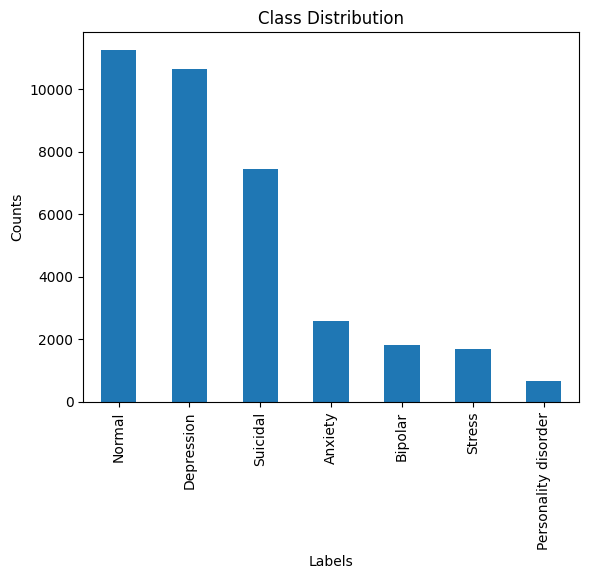

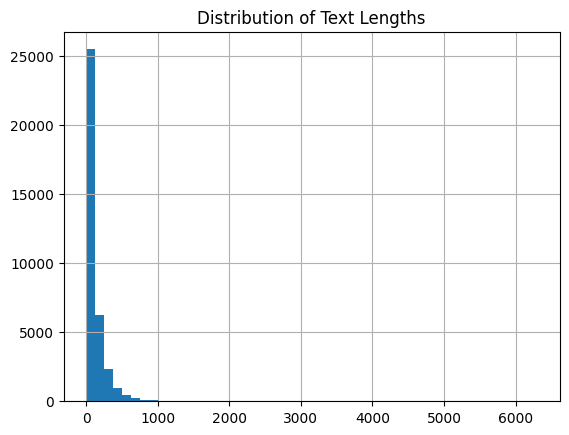

In [2]:
#Load Data and drop nulls
df = load_data("data/Sentiment_analysis_dataset.csv")
df = clean_data(df)
check_class_distribution(df)
df = add_text_length(df)
check_text_length_distribution(df)
    

None


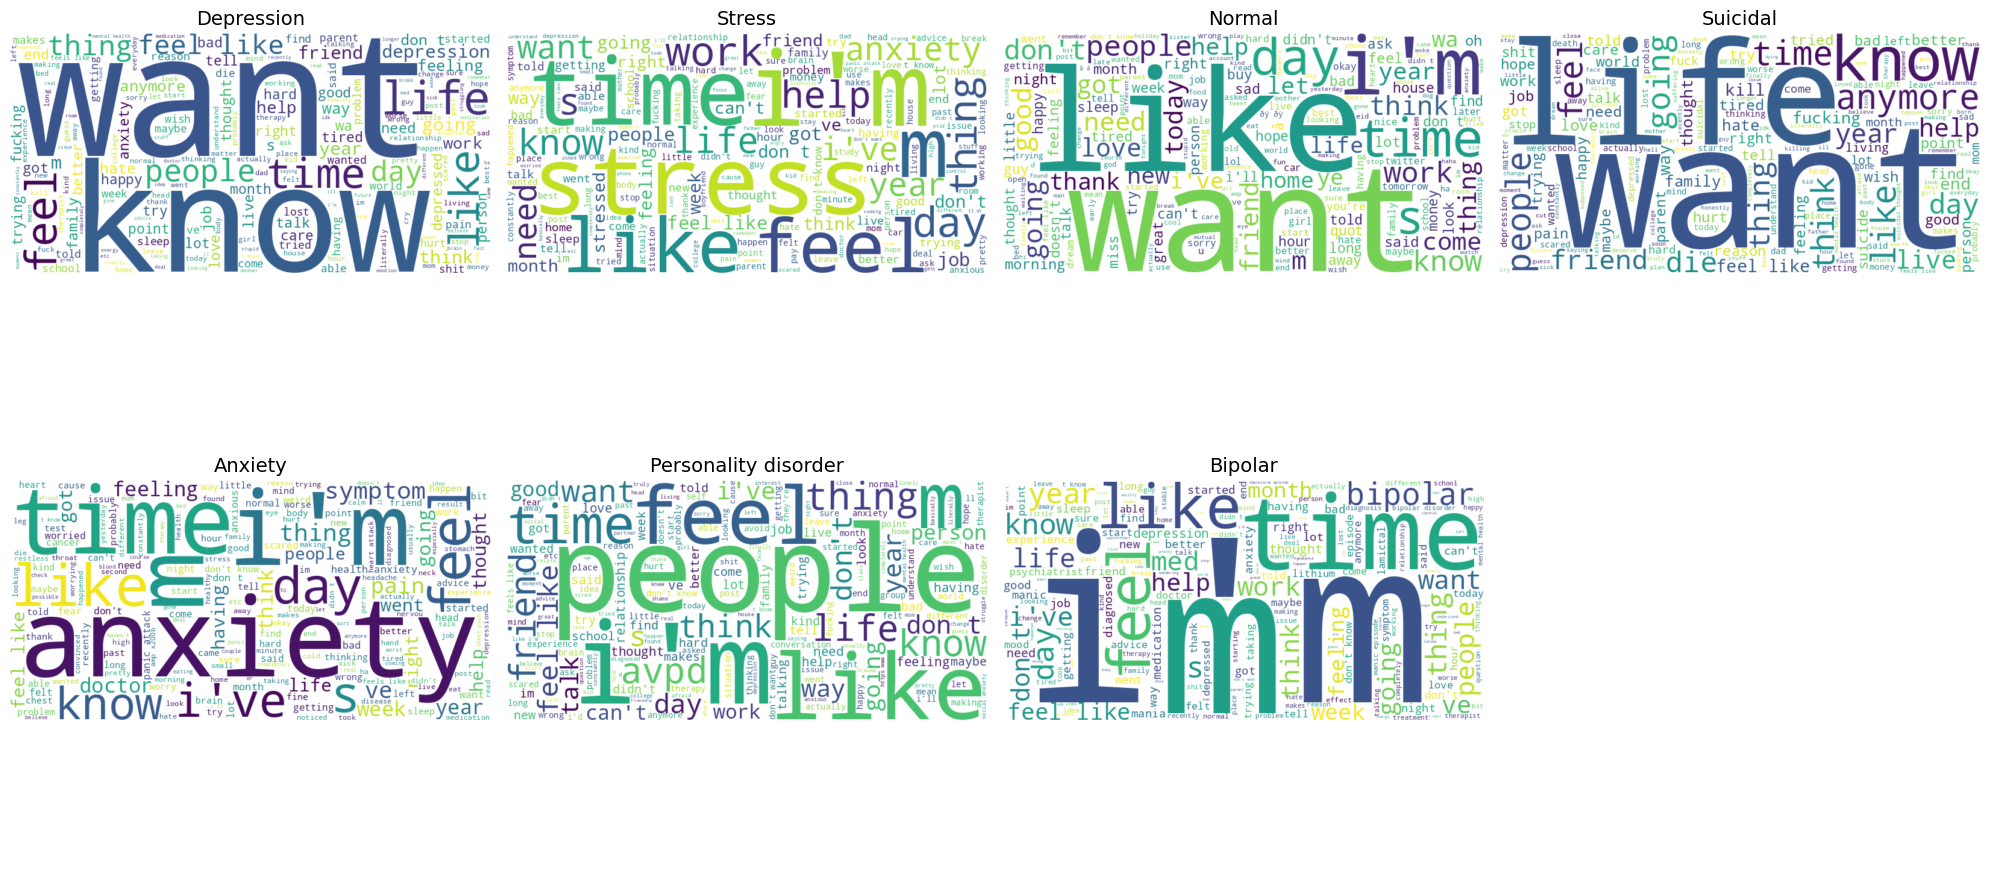

In [3]:
# Clean text

if not os.path.exists("clean_df.pkl"):
    df['CleanText'] = df['Statement'].apply(preprocess)
    joblib.dump(df, "clean_df.pkl")
else:
    df = joblib.load("clean_df.pkl")
    
if not os.path.exists("word_freq.pkl"):
    freq_data = get_clean_word_freq(df)
    joblib.dump(freq_data, "word_freq.pkl")
else:
    freq_data = joblib.load("word_freq.pkl")
    print(freq_data)
    
visualize_word_clouds(df)


In [4]:
# # Extract features
X_tfidf, tfidf = extract_features(df)
y, le = encode_labels(df)
    
# # Split data
X_train, X_val, X_test, y_train, y_val, y_test = split_data(X_tfidf, y)
    
# # # Handle class imbalance
X_train_resampled, y_train_resampled = handle_imbalance(X_train, y_train)


Train size: 28864 | Val: 3608 | Test: 3608


In [5]:
# Train Logistic regression model
lr_model = load_model_if_exists("LogisticRegression")

if lr_model is None:
    lr_model = train_lr_model(X_train_resampled, y_train_resampled)
    evaluate_model(lr_model, X_val, y_val, le)
    save_model(lr_model)

Model 'LogisticRegression' already exists. Loading from file.


In [6]:
#train random forest model
rf_model = load_model_if_exists("RandomForestClassifier")

if rf_model is None:
    rf_model = train_rf_model(X_train_resampled, y_train_resampled)
    evaluate_model(rf_model, X_val, y_val, le)
    save_model(rf_model)

Model 'RandomForestClassifier' already exists. Loading from file.


In [7]:
#train naive bayes model
nb_model = load_model_if_exists("MultinomialNB")

if nb_model is None:
    nb_model = train_nb_model(X_train_resampled, y_train_resampled)
    evaluate_model(nb_model, X_val, y_val, le)
    save_model(nb_model)

Model 'MultinomialNB' already exists. Loading from file.


In [8]:
#train neural network
cnn_model = load_model_if_exists("Sequential")

if cnn_model is None:
    cnn_model = train_cnn_model(X_train_resampled, y_train_resampled, X_val, y_val, y_test)
    evaluate_model_nn(cnn_model, X_val, y_val, le)
    save_model(cnn_model)

Model 'Sequential' already exists. Loading from file.


In [9]:
#train xgboost model
xgb_model = load_model_if_exists("XGBClassifier")

if xgb_model is None:
    xgb_model = train_xgb_model(X_train_resampled, y_train_resampled)
    evaluate_model(xgb_model, X_val, y_val, le)
    save_model(xgb_model)

Model 'XGBClassifier' already exists. Loading from file.


In [10]:
#saving the dataset
df.to_csv("data/cleaned_sentiment_dataset.csv", index=False)

In [11]:
#viewing all of the models
summary_of_models()

                    Model  Accuracy  Macro Precision  Macro Recall  Macro F1  \
4           XGBClassifier  0.724778         0.670500      0.647455  0.654616   
0      LogisticRegression  0.697894         0.616719      0.673149  0.634510   
2           NeuralNetwork  0.700942         0.659464      0.589295  0.614360   
3  RandomForestClassifier  0.701220         0.672678      0.583458  0.607547   
1           MultinomialNB  0.587860         0.503659      0.608263  0.518684   

   Weighted Precision  Weighted Recall  Weighted F1  
4            0.722687         0.724778     0.722048  
0            0.725868         0.697894     0.706757  
2            0.700218         0.700942     0.698441  
3            0.692471         0.701220     0.691896  
1            0.669964         0.587860     0.606469  


In [12]:
#xgb is the best model so we will choose that for testing

y_pred_test = xgb_model.predict(X_test)
y_pred_labels = le.inverse_transform(y_pred_test)

pred_df = pd.DataFrame({
    'Predicted Label': y_pred_labels
})

pred_df.to_csv("data/xgb_test_predictions.csv", index=False)
print("Predictions saved to xgb_test_predictions.csv")
print(classification_report(y_test, y_pred_test, target_names=le.classes_))



Predictions saved to xgb_test_predictions.csv
                      precision    recall  f1-score   support

             Anxiety       0.72      0.74      0.73       259
             Bipolar       0.79      0.69      0.74       180
          Depression       0.70      0.62      0.66      1063
              Normal       0.83      0.92      0.87      1127
Personality disorder       0.64      0.52      0.57        66
              Stress       0.42      0.45      0.43       168
            Suicidal       0.63      0.63      0.63       745

            accuracy                           0.72      3608
           macro avg       0.67      0.65      0.66      3608
        weighted avg       0.72      0.72      0.72      3608



In [13]:
accuracy_score(y_test, y_pred_test)

0.7195121951219512